# Определение возраста покупателей

## Описание проекта

Сетевой **супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей** с Фотофиксацией в прикассовой зоне.

Это поможет определять возраст клиентов, чтобы:
1.Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2.Контролировать добросовестность кассиров при продаже алкоголя.
 
**Задача проекта:** построить модель, которая по фотографии определит приблизительный возраст человека. 

**Данные:** набор фотографий людей с указанием возраста.

**План работы:**
1. Проведем исследовательский анализ набора фотографий.
2. Подготовим данные к обучению.
3. Обучим нейронную сеть и рассчитаем её качество.

## Исследовательский анализ данных

Импортируем библиотеки.

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt 
import seaborn as sns

Считываем данные из файла.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Посмотрим, что у нас за данные.

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Посмотрим какие данные по возрасту у нас есть в выборке.

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Сгруппируем данные по группам. 

In [5]:
labels['age_group'] = pd.cut(labels['real_age'], bins=10)
labels.groupby('age_group')['real_age'].agg(['count','median'])

,count,median
age_group,,
"(0.901, 10.9]",708,4.0
"(10.9, 20.8]",1346,17.0
"(20.8, 30.7]",2214,26.0
"(30.7, 40.6]",1414,35.0
"(40.6, 50.5]",929,45.0
"(50.5, 60.4]",534,55.0
"(60.4, 70.3]",254,65.0
"(70.3, 80.2]",111,75.0
"(80.2, 90.1]",68,86.5


Построем график распределения возраста в выборке.

[Text(0.5, 1.0, 'age distribution')]

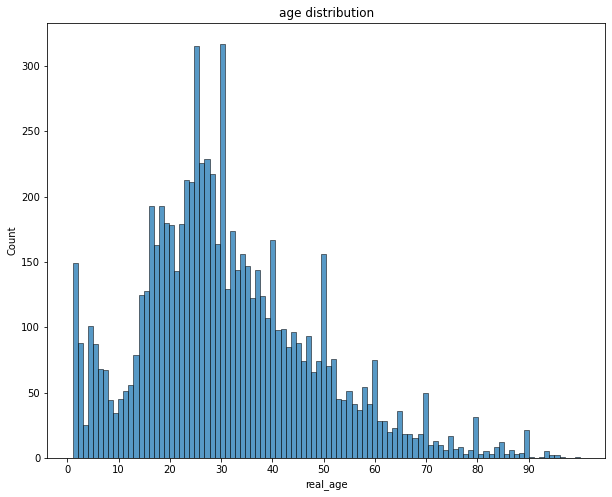

In [6]:
plt.figure(figsize=(10,8))
plt.xticks(np.arange(0, 100, 10))
sns.histplot(labels['real_age'], palette="paired", bins=100).set(title='age distribution')

По графику видны пики в значениях, кратных 10. Есть вероятность, что "круглые" данные вносились в датасет вручную и округлялись до юбилейных "значений".

Создадим класс ImageDataGenerator. Он сформирует батчи с изображениями. Поделим значения яркости на 255.

In [7]:
train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

Вызовем функцию flow_from_directory(), чтобы загрузчик извлёк данные из папки:

In [8]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Загрузчик нашёл 7591 изображений. Посмотрим, что за фото у нас в выборке.

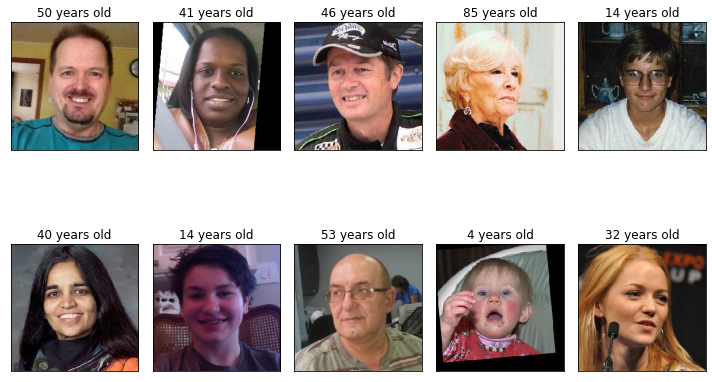

In [9]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]} years old')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В выборке есть данные как с цветными так и с черно-белыми фотографиями.Есть повернутые фотографии, но не перевернутые. Т.е. их нужно поворачиваеть, но не переворачивать. Также изображения различаются(немного) по размеру. Также мы видим, что и разрешение на фотографиях значительно отичается.


Все это может помешать нам при обучении модели.


Потому,при загрузке изображений, мы все приведем к одному формату - 224 х 224 пикселя. Будем масштабировать значение каждого пикселя в диапазон от 0 до 1(rescale=1./255). Для устранения поворотов фото укажем в ImageDataGenerator: horizontal_flip растягивание по горизонтали. Но применим его только на обучающей выборке. В тренировочных данных модель должна сама подстроится под подобные изображения.

## Обучение модели

Код запускался в отдельном GPU-тренажёре, потому оформлен в текстовой ячейке.
Мы построили свёрточную нейронную сеть на датасете с фотографиями людей. Работу сети запускали с помощью след функций:

1. Функции загрузки обучающей load_train и тестовой выборок load_test(path) 
2. Функиця создания модели create_model(input_shape)
3. Функция запуска и обучения модели train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)

Результаты обучения на тренажере.

## Анализ обученной модели